## Morning session - Geospatial Cloud Workshop

Morning session is an introduction to STAC, odc-stac, pystac_client

In [14]:
import pandas as pd
from odc.stac import configure_s3_access, load
from pystac_client import Client as pystac_client
from dask.distributed import Client as d_client
import numpy as np
import geopandas as gpd
import odc.geo.xr

from eo_insights.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

- Check with Alex and Caitlin - dask dashboard not working, is this because I'm inside a dev container?

In [15]:
dask_client = d_client()
dask_client

/home/vscode/.local/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34449 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:36561' processes=5 threads=20, memory=31.26 GiB>

In [16]:
aoi_path = "/workspaces/cloud-native-geospatial-eo-workshop/aoi_workshop.geojson"
aoi = gpd.read_file(aoi_path)

#aoi.explore()

In [17]:
catalog = "https://explorer.dea.ga.gov.au/stac"

stac_client = pystac_client.open(catalog)

configure_s3_access(
    cloud_defaults = True,
    aws_unsigned = True
)

In [18]:
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)

# Why is height a string?

geom = select_on_a_map(
    height = "500px",
    layers = (basemap,),
    center = (-26, 153),
    zoom = 4
)

Map(center=[-26, 153], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [33]:
date_range = ["2022-10", "2022-12"]

collections_ga = ["ga_s2am_ard_3", "ga_s2bm_ard_3"]

filter_cloud = "s2cloudless:cloud < 20"

In [34]:
items = stac_client.search(
    collections = collections_ga,
    intersects = geom,
    datetime = date_range,
    filter = filter_cloud
).item_collection()


In [36]:
items

In [44]:
ds_filtered = load(
    items,
    bands = ['nbart_nir_1', 'nbart_red', 'nbart_blue'],
    crs = "utm",
    chunks = {},
    resolution = 30,
    groupby = "solar_day",
    geopolygon = geom
).compute()

In [45]:
ds_filtered

<xarray.Dataset> Size: 42MB
Dimensions:      (y: 708, x: 814, time: 6)
Coordinates:
  * y            (y) float64 6kB 5.713e+06 5.712e+06 ... 5.691e+06 5.691e+06
  * x            (x) float64 7kB 4.17e+05 4.17e+05 ... 4.413e+05 4.413e+05
    spatial_ref  int32 4B 32755
  * time         (time) datetime64[ns] 48B 2022-10-04T00:17:45.929731 ... 202...
Data variables:
    nbart_nir_1  (time, y, x) float32 14MB nan nan nan ... 3.529e+03 3.359e+03
    nbart_red    (time, y, x) float32 14MB nan nan nan ... 1.987e+03 1.85e+03
    nbart_blue   (time, y, x) float32 14MB nan nan nan ... 1.822e+03 1.753e+03

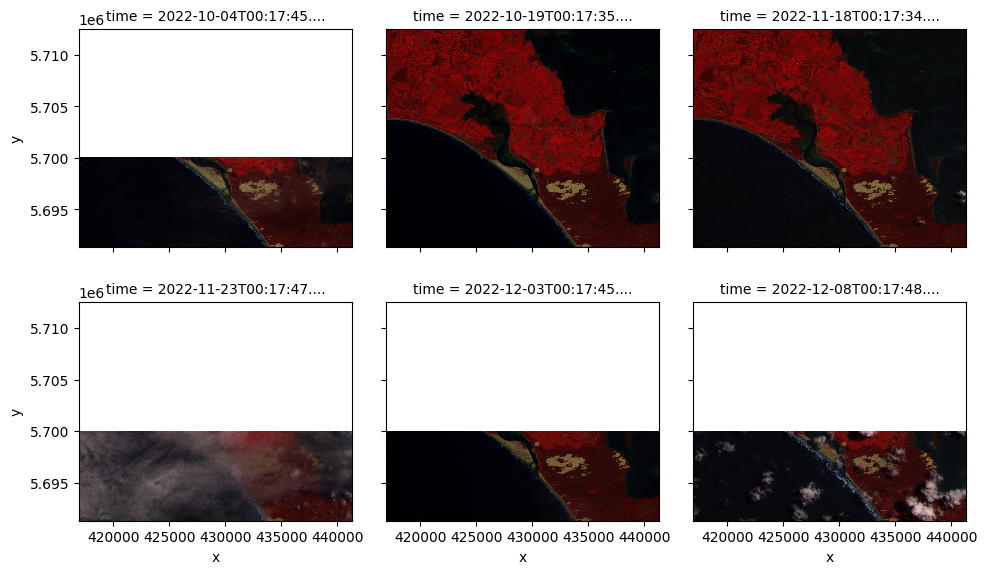

In [46]:
ds_filtered.to_array().plot.imshow(
    col="time",
    col_wrap = 3
)

In [48]:
best_image_date = "2022-11-18"

best_image = ds_filtered.sel(time=best_image_date).squeeze()

best_image

<xarray.Dataset> Size: 7MB
Dimensions:      (y: 708, x: 814)
Coordinates:
  * y            (y) float64 6kB 5.713e+06 5.712e+06 ... 5.691e+06 5.691e+06
  * x            (x) float64 7kB 4.17e+05 4.17e+05 ... 4.413e+05 4.413e+05
    spatial_ref  int32 4B 32755
    time         datetime64[ns] 8B 2022-11-18T00:17:34.957063
Data variables:
    nbart_nir_1  (y, x) float32 2MB 5.146e+03 3.943e+03 ... 2.139e+03 2.279e+03
    nbart_red    (y, x) float32 2MB 281.0 225.0 302.0 ... 298.0 260.0 296.0
    nbart_blue   (y, x) float32 2MB 271.0 249.0 301.0 ... 246.0 215.0 235.0

In [50]:
viz = best_image.odc.to_rgba(bands=["nbart_nir_1", "nbart_red", "nbart_blue"])

viz.odc.explore()

In [51]:
viz_array = best_image.to_array().values

percentile_stretch = (1,99)

stretch_vmin, stretch_vmax = np.nanpercentile(viz_array, percentile_stretch)

In [52]:
viz_stretch = best_image.odc.to_rgba(
    bands = ["nbart_nir_1", "nbart_red", "nbart_blue"],
    vmin = stretch_vmin,
    vmax = stretch_vmax
)

viz_stretch.odc.explore()

In [53]:
# viz_stretch.odc.write_cog("sentinel2_example.tif", overwrite = True)

PosixPath('sentinel2_example.tif')